# A very simple NN example on the MNIST open dataset



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128) # 9216 = 64*((28-2-2)/2)*((28-2-2)/2);  -2 is due to the 2 cov op, /2 is due to the max pooling op
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = nn.Dropout(0.25)(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = nn.Dropout(0.5)(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [2]:
model = Net()
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

forward()里面出现的max pooling, dropout, relu, log softmax等未出现在上面的model结构中,因为它们都是运算层,不涉及可训练的参数


(dot.exe:55740): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


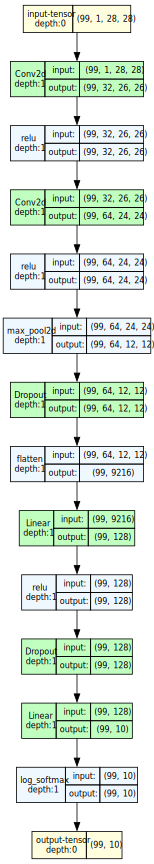

In [3]:
from torchview import draw_graph

batch_size = 99
model_graph = draw_graph(model, input_size=(batch_size, 1, 28, 28), expand_nested=True) # device='meta', 
model_graph.visual_graph

In [5]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset1 = datasets.MNIST('../../data/', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../../data/', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size, shuffle=True)

Training set - the first 10  samples
Input size:  torch.Size([1, 28, 28])


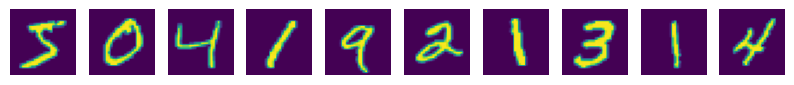

In [6]:
import matplotlib.pyplot as plt

N = 10
print("Training set - the first", N, " samples")
print("Input size: ", dataset1[0][0].shape)

plt.figure(figsize = (N,1))
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(dataset1[i][0].numpy().transpose(1, 2, 0))
    plt.axis('off')
plt.show()

Test set - the first 10  samples
Input size:  torch.Size([1, 28, 28])


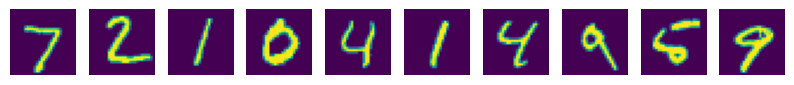

In [7]:
import matplotlib.pyplot as plt

print("Test set - the first", N, " samples")
print("Input size: ", dataset1[0][0].shape)

plt.figure(figsize = (N,1))
for i in range(N):
    plt.subplot(1,N,i+1)
    plt.imshow(dataset2[i][0].numpy().transpose(1, 2, 0))
    plt.axis('off')
plt.show()

In [8]:
device = "cuda"

model.to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0) # Adadelta梯度下降
scheduler = StepLR(optimizer, step_size=1, gamma=.7) # LR衰减

for epoch in range(20):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) # NLLLoss computes the negative log likelihood loss for a classification problem
        # loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    scheduler.step()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305267
Train Epoch: 0 [9900/60000 (16%)]	Loss: 0.229154
Train Epoch: 0 [19800/60000 (33%)]	Loss: 0.163216
Train Epoch: 0 [29700/60000 (49%)]	Loss: 0.120317
Train Epoch: 0 [39600/60000 (66%)]	Loss: 0.153574
Train Epoch: 0 [49500/60000 (82%)]	Loss: 0.113316
Train Epoch: 0 [59400/60000 (99%)]	Loss: 0.175743

Test set accuracy: 9600/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.140689
Train Epoch: 1 [9900/60000 (16%)]	Loss: 0.043147
Train Epoch: 1 [19800/60000 (33%)]	Loss: 0.024239
Train Epoch: 1 [29700/60000 (49%)]	Loss: 0.032439
Train Epoch: 1 [39600/60000 (66%)]	Loss: 0.016874
Train Epoch: 1 [49500/60000 (82%)]	Loss: 0.132262
Train Epoch: 1 [59400/60000 (99%)]	Loss: 0.030020

Test set accuracy: 9820/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.019498
Train Epoch: 2 [9900/60000 (16%)]	Loss: 0.059795
Train Epoch: 2 [19800/60000 (33%)]	Loss: 0.029425
Train Epoch: 2 [29700/60000 (49%)]	Loss: 0.010898
Train Epoch: 2 [39600/60000 (66%)]	Loss: 0